# Bayesian Convolutional Neural Network with Variational Inference

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt

from edward.models import Normal, Categorical
from sklearn.model_selection import train_test_split
from tensorflow.examples.tutorials.mnist import input_data
from scipy.interpolate import UnivariateSpline

from tqdm import tqdm
plt.style.use('ggplot')

## Load Data

In [2]:
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
X_train = mnist.train.images
y = mnist.train.labels

### Small data
Bayesian models are extremely powerful when dealing with less data. Training data with 500 samples can give 90%+ accuracy. 

In [6]:
X_train, X_test, y, y_test = train_test_split(
     X_train, y, test_size=0.995, random_state=42, stratify=y)

In [4]:
X_train.shape

(55000, 784)

In [5]:
X_test = mnist.test.images
y_test = mnist.test.labels

### Parameters

In [6]:
#Size of training data
N = X_train.shape[0]
#Dimensions of input placeholder
I = X_train.shape[1]

#Possible output labels
K = 10
#Batch size
M = 128
#Size of hidden units
H= 1024
#Number of initial convolution features
U= 32

#Dimension of input to FC layer
D = 7*7*(U*2)

## Create Batches

In [7]:
def generator(arrays, batch_size):
  """Generate batches, one with respect to each array's first axis."""
  starts = [0] * len(arrays)  # pointers to where we are in iteration
  while True:
    batches = []
    for i, array in enumerate(arrays):
      start = starts[i]
      stop = start + batch_size
      diff = stop - array.shape[0]
      if diff <= 0:
        batch = array[start:stop]
        starts[i] += batch_size
      else:
        batch = np.concatenate((array[start:], array[:diff]))
        starts[i] = diff
      batches.append(batch)
    yield batches
data = generator([X_train, y], M)

## Model

In [23]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides= [1,1,1,1], padding= "SAME")

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize= [1,2,2,1], strides= [1,2,2,1], padding= "SAME")

In [24]:
def weight(shape):
    return Normal(loc=tf.zeros(shape), scale=tf.ones(shape))

def bias(shape):
    return Normal(loc=tf.zeros(shape), scale=tf.ones(shape))
    
def variables():
    var = {}
    #Placeholder variables for input and output
    var['x'] = tf.placeholder(tf.float32, shape=[None, I])
    var['y'] = tf.placeholder(tf.int32, shape=[None])
    
    #loc is the mean and scale is the variance
    var['Wconv0'] = weight([5,5,1,U])
    var['bconv0'] = bias([U])
    
    var['Wconv1'] = weight([5,5,U,U*2])
    var['bconv1'] = bias([U*2])

    var['W0'] = weight([D, H])
    var['b0'] = bias(H)

    var['W1'] = weight([H, K])
    var['b1'] = bias(K)

    return (var)

In [25]:
def model(var):
    x = var['x']

    x = tf.reshape(x, [-1, 28, 28, 1])
    
    #Convolution layer 1
    x = tf.nn.tanh(conv2d(x, var['Wconv0']) + var['bconv0'] )
    x = max_pool_2x2(x)
    
    #Convolution layer 2
    x = tf.nn.tanh(conv2d(x, var['Wconv1']) + var['bconv1'])
    x = max_pool_2x2(x)
    
    #Flatten
    x = tf.reshape(x, [-1, D])
    
    #FC layer 1
    x = tf.nn.tanh(tf.matmul(x, var['W0']) + var['b0'])
    
    #FC layer 2
    x = tf.matmul(x, var['W1']) + var['b1']
    
    logits = x
    
    output = Categorical(logits)
    
    return output

In [26]:
def qweight(shape):
    return Normal(loc=tf.Variable(tf.random_normal(shape)),
                  scale=tf.nn.softplus(tf.Variable(1/100 *tf.random_normal(shape))))

def qbias(shape):
    return Normal(loc=tf.Variable(tf.random_normal(shape)),
                  scale=tf.nn.softplus(tf.Variable(1/100 *tf.random_normal(shape))))

def approximation_variables():
    qvar = {}
    
    qvar['Wconv0'] = qweight([5,5,1,U])
    qvar['bconv0'] = qbias([U])
    
    qvar['Wconv1'] = qweight([5,5,U,U*2])
    qvar['bconv1'] = qbias([U*2])

    qvar['W0'] = qweight([D, H])
    qvar['b0'] = qbias([H])
                     
    qvar['W1'] = qweight([H, K])
    qvar['b1'] = qbias([K])
    
    return qvar

## Inference

In [39]:
var = variables()
output = model(var)
qvar = approximation_variables()

inference_dict = {var[key]: val for key, val in qvar.items()}
inference = ed.KLqp(inference_dict, data={output:var['y']})

#Number of batches with the specified batch size
n_batch = int(N / M)
n_epoch = 3

inference.initialize(n_iter=n_batch*n_epoch, n_samples=10,
                     scale={output: n_batch})
tf.global_variables_initializer().run()

In [40]:
for _ in range(inference.n_iter):
    X_batch, y_batch = next(data)
    for _ in range(10):
        info_dict = inference.update(feed_dict={var['x']: X_batch, var['y']: y_batch})
    print('Loss: ',info_dict,  end="\r", flush=True)


## Criticism/Evaluation

In [50]:
#Out of distribution data for evaluating uncertainty estimation quality
nmnist = input_data.read_data_sets("notMNIST_data/")
X_test = nmnist.test.images
y_test = nmnist.test.labels

Extracting notMNIST_data/train-images-idx3-ubyte.gz
Extracting notMNIST_data/train-labels-idx1-ubyte.gz
Extracting notMNIST_data/t10k-images-idx3-ubyte.gz
Extracting notMNIST_data/t10k-labels-idx1-ubyte.gz


In [51]:
n_samples = 50
pred_lst = []
#Make sample models drawn from posterior evaluated on the test set
for _ in tqdm(range(n_samples)):
    param_post = {key: qvar[key].sample()
                      if key in qvar else var[key]
                      for key in var}
    preds = tf.nn.softmax(model(param_post).logits)
    np_preds = preds.eval(feed_dict={param_post['x']: X_test})
    pred_lst.append(np_preds)


100%|██████████| 50/50 [00:33<00:00,  1.47it/s]


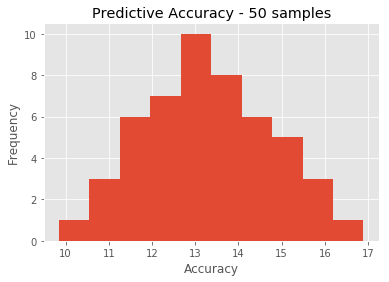

In [52]:
accy_test = []
for pred in pred_lst:
    y_trn_prd = np.argmax(pred,axis=1).astype(np.float32)
    acc = (y_trn_prd == y_test).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.title("Predictive Accuracy - 50 samples")
plt.show()

In [53]:
#Model Averaging
y_pred = np.argmax(np.mean(pred_lst,axis=0),axis=1)
print(" Accuracy on test set= ", (y_pred == y_test).mean()*100)

 Accuracy on test set=  13.7


In [54]:
preds = np.argmax(np.array(pred_lst),axis=2)

truth =  1


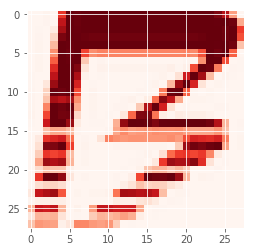

In [55]:
test_ind =1178
test_image = X_test[test_ind]
test_label = y_test[test_ind]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels, cmap='Reds');

(array([  0.,   0.,   0.,  43.,   7.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

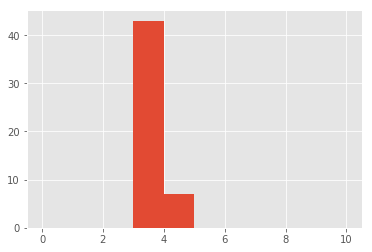

In [56]:
plt.hist((preds[:, test_ind]),bins=range(11))

In [57]:
entropies1 = []
n=len(y_test)

def predictive_entropy(prob):
        return -1 * np.sum(np.log(prob) * prob, axis=0)
for x in tqdm(range(n)):
    p, _ = np.histogram(preds[:,x], bins=range(10), normed=True)
    entropies1.append(predictive_entropy(p[p != 0]))

100%|██████████| 10000/10000 [00:00<00:00, 13874.06it/s]


Text(0.5,1,'MNIST - 0.1803')

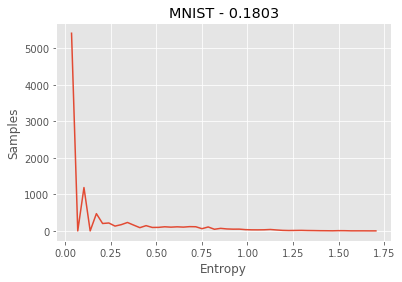

In [67]:
p, x = np.histogram(entropies, bins=50)
plt.plot(x[1:], p)
plt.xlabel("Entropy")
plt.ylabel("Samples")
sum_ent=np.float16(np.sum(entropies)/n)
plt.title("MNIST - %s" %sum_ent)

This was a demonstration of Bayesian deep neural networks with Edward. An interesting follow up excersice is to prune weights, i.e., set uncertain weights to 0. [This](https://arxiv.org/pdf/1505.05424.pdf) paper shows that it is possible to prune weights with high signal to noise ratio with minimal hit on accuracy. Weights to prune can be identified by
$$\frac{|\mu_i|}{\sigma_i}$$
A bayesian model gives us both mean and variance of a weight and all we need to do is identify the weights with the smallest ratios and set n% of them to 0. Here is some code to make this clearer. 
Hint:This can lead to some interesting observations. Pruning weights may not actually be a good thing.

In [70]:
b1 = qvar['b1']

mean = b1.mean().eval()
std = b1.stddev().eval()

np.abs(mean)/std

array([ 0.67664266,  0.31034687,  6.23156929,  1.44606054,  3.39092922,
        3.11480641,  3.05162883,  1.23227096,  3.20465231,  7.10845947], dtype=float32)

## References
- Edward [Tutorials](http://edwardlib.org/tutorials/)
- Alpha-I Blog [Post](https://www.alpha-i.co/blog/MNIST-for-ML-beginners-The-Bayesian-Way.html)
- Tensorflow [Tutorial](https://www.tensorflow.org/tutorials/layers)
- Uncertainty in weights [paper](https://arxiv.org/pdf/1505.05424.pdf)